This is a retrospective exploratory data analysis of our ESPN Fantasy Football league data at the end of Week 17 for the 2021 season. The code can be re-used for any past season using the same ESPN API.

I used the [sportsipy API](https://sportsreference.readthedocs.io/en/stable/nfl.html) for NFL schedules and [Christian Wendt's ESPN Fantasy Football API](https://github.com/cwendt94/espn-api) to extract ESPN league-specific data.

For data visualization, I used the [Altair Data Visualization Library](https://altair-viz.github.io/). Altair was chosen for its interactivity, especially for its ability to display hover data and the compatibility of interactive plots with GitHub Pages.

In [4]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import altair as alt

# import datetime
from datetime import date
from datetime import datetime

import requests
import espn_api
from espn_api.football import League
from espn_api.football import activity

import sportsipy.nfl
from sportsipy.nfl.boxscore import Boxscore
from sportsipy.nfl.schedule import Schedule
from sportsipy.nfl.teams import Teams
import nfl_data_py as nfl

from sportsipy.nfl.teams import Teams

In [5]:
year_of_interest = 2021

df_games = nfl.import_schedules([year_of_interest])

teams = Teams()

df_team_names = pd.DataFrame(columns = ['Pro Team Name' , 'Abbrev'])
abbrev_ls = []
team_name_ls = []

for team in teams:
    abbrev_ls.append(team.abbreviation)
    team_name_ls.append(team.name)
    
df_team_names['Pro Team Name'] = team_name_ls
df_team_names['Abbrev'] = abbrev_ls

df_team_names.sort_values('Pro Team Name',ascending=True,inplace=True)

df_team_names.to_csv('abbrev_names.csv')

df_team_name_convert = pd.read_csv('team_abbrev_conversion.csv').set_index('Abbrev_sportsipy')

conv_dict = df_team_name_convert['Abbrev'].to_dict()

df_proteam_schedule = pd.read_csv('team_abbrev.csv' , index_col=False).drop(['Unnamed: 0'],axis=1).set_index('Abbrev_sportsipy')

pro_team_ls = df_proteam_schedule.index.tolist()


## Build NFL team schedules with dates

In [6]:
# series for each NFL team:
games_all_season = 18

wk_ls = [i+1 for i in list(range(games_all_season))]

df_proteam_schedules = pd.DataFrame(data=[], index=wk_ls , columns = pro_team_ls)

In [7]:
for i in pro_team_ls:
    proteam_schedule = Schedule(i)
    
    for game in proteam_schedule:
        game_time = game.datetime.date()
        wk = game.week
        
        df_proteam_schedules.loc[wk,i] = game_time
        
df_proteam_schedules.fillna('BYE',inplace=True)

df_proteam_schedules.rename(columns = conv_dict , inplace=True)

In [11]:
df_proteam_schedules.head()

,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,DEN,...,NO,NYG,NYJ,PHI,PIT,SF,SEA,TB,TEN,WSH
1,2021-09-12,2021-09-12,2021-09-13,2021-09-12,2021-09-12,2021-09-12,2021-09-12,2021-09-12,2021-09-09,2021-09-12,...,2021-09-12,2021-09-12,2021-09-12,2021-09-12,2021-09-12,2021-09-12,2021-09-12,2021-09-09,2021-09-12,2021-09-12
2,2021-09-19,2021-09-19,2021-09-19,2021-09-19,2021-09-19,2021-09-19,2021-09-19,2021-09-19,2021-09-19,2021-09-19,...,2021-09-19,2021-09-16,2021-09-19,2021-09-19,2021-09-19,2021-09-19,2021-09-19,2021-09-19,2021-09-19,2021-09-16
3,2021-09-26,2021-09-26,2021-09-26,2021-09-26,2021-09-23,2021-09-26,2021-09-26,2021-09-26,2021-09-27,2021-09-26,...,2021-09-26,2021-09-26,2021-09-26,2021-09-27,2021-09-26,2021-09-26,2021-09-26,2021-09-26,2021-09-26,2021-09-26
4,2021-10-03,2021-10-03,2021-10-03,2021-10-03,2021-10-03,2021-10-03,2021-09-30,2021-10-03,2021-10-03,2021-10-03,...,2021-10-03,2021-10-03,2021-10-03,2021-10-03,2021-10-03,2021-10-03,2021-10-03,2021-10-03,2021-10-03,2021-10-03
5,2021-10-10,2021-10-10,2021-10-11,2021-10-10,2021-10-10,2021-10-10,2021-10-10,2021-10-10,2021-10-10,2021-10-10,...,2021-10-10,2021-10-10,2021-10-10,2021-10-10,2021-10-10,2021-10-10,2021-10-07,2021-10-10,2021-10-10,2021-10-10


## Import data from ESPN Fantasy Football

In [12]:
league_id = 1094090
year = year_of_interest
SWID="{F191FB8C-DB2D-4D24-91FB-8CDB2DED249D}"

s2='AECJMQHsUHB0FTXdZkw93uY7GRbX8BPnm93Ye6AwvwrMsrZFGg1Lbmi07SWVov2ioN8zGMFDzZiiDSeQCa7WQHaGivGnMfGWLjmfGwkOeLXb5baD1sltp%2B%2BIfHAtl98TpmHgB16ZpGn6g3Bm5vLEA7yDC6HkbD3LSp0E2rGB7hKziLMvZ7mT6ONJFRe8Xp3ApYWSvxPr9cz0pJiI%2FF0blsZ8hyATDJMEyaQ2O%2FypcsViORr6hqYTmXHPuPKnMBfvYC8LQqi1exGw3vnyg6ptsB2Y'

league = League(league_id=league_id, year=year, espn_s2=s2, swid=SWID)

activity_ls = league.recent_activity(400)

## Build Acquisitions Dataframe

In [13]:
import datetime

# Function handling trade data

def get_trade_data(j):
    
    acq_data_ls = []

    date1 = j.date

    team_transaction_ls = []
    
    for k in j.actions:
        (team1, action1, _ , _ ) = k
        team_id = team1.team_name
        team_transaction_ls.append(team_id)

        # determine if trade or waiver acquisition type

    # establish other team involved in trade
    teams_in_trade = list(set(team_transaction_ls))

    for k in j.actions:
        (team1, action1, player_name, bid_amount) = k
        team_id = team1.team_name
    #     print(team_id)

        if teams_in_trade.index(team_id) == 1:
            team_id_received = teams_in_trade[0]
        else:
            team_id_received = teams_in_trade[1]

        # Build new tuple for TRADE ADDED
    #     team_id = team_id_received
        player_id = player_name.name
        ProTeam = player_name.proTeam
        action1 = 'TRADE ADDED'

        # Build a second tuple for TRADE DROPPED
        action2 = 'TRADE DROPPED'

        acq_data1 = (date1 , player_id , ProTeam , team_id_received , action1, bid_amount)
        drop_data1 = (date1 , player_id , ProTeam , team_id , action2, bid_amount)

        acq_data_ls.append(acq_data1)
        acq_data_ls.append(drop_data1)
        
    return acq_data_ls

In [14]:
# Function handling waiver data
def get_waiver_data(j):
    
    waiver_data_ls = []

    for k in j.actions:
        (team1, action1, player_name, bid_amount) = k
        team_id = team1.team_name
        player_id = player_name.name
        ProTeam = player_name.proTeam
        
#         total_points = player_name.stats[0]['points']
        waiver_data1 = (date1 , player_id , ProTeam , team_id , action1 , bid_amount)
        waiver_data_ls.append(waiver_data1)
        
    return waiver_data_ls

In [15]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [16]:
# Conditional for trade or waiver acquisitions

acq_data_ls = []

# date1 = activity_ls[traded_idx].date

# loop through each activity item
for idx, j in enumerate(activity_ls):
    date1 = j.date
    team_transaction_ls = []
    for k in j.actions:
        (team1, action1, _ , _ ) = k
        team_id = team1.team_name
        team_transaction_ls.append(team_id)
        
        # determine if trade or waiver acquisition type
        
        ls = []
        
        if action1 == 'TRADED':
            ls = get_trade_data(j)

        else:
            ls = get_waiver_data(j)

    acq_data_ls.append(ls)
      

acq_data_flat_ls = flatten_list(acq_data_ls)

df_acq = pd.DataFrame(acq_data_flat_ls)

df_acq.columns = ['Timestamp','Player','ProTeam','Team','Action','Bid Amount ($)']

# converts from milliseconds to date
def convert_to_date(date1):
    d2=datetime.date.fromtimestamp(date1 / 1000.0)
    return d2

df_acq['Action Timestamp'] = df_acq['Timestamp'].apply(lambda x : convert_to_date(x))

df_acq = df_acq.sort_values(by=['Timestamp'],ascending=True)

In [17]:
df_acq.head()

,Timestamp,Player,ProTeam,Team,Action,Bid Amount ($),Action Timestamp
598,1631199616099,Dolphins D/ST,MIA,Ice City USA,DROPPED,0,2021-09-09
590,1631199616099,Rodrigo Blankenship,IND,Fumble .,DROPPED,0,2021-09-09
591,1631199616099,T.Y. Hilton,IND,Fumble .,WAIVER ADDED,1,2021-09-09
592,1631199616099,Deshaun Watson,HOU,Frankel's Cankles,DROPPED,0,2021-09-09
597,1631199616099,Vikings D/ST,MIN,Ice City USA,WAIVER ADDED,0,2021-09-09


## Get Draft Data

In [18]:
draft_ls = []
for i in league.draft:
    
    team_id = i.team.team_name
    player_id = i.playerName
    bid_amount = i.bid_amount
    action = 'DRAFT ADDED'
    
    draft_ls.append((player_id, team_id,action,bid_amount))

df_draft = pd.DataFrame(draft_ls)
  
df_draft.columns = ['Player', 'Acquired by' , 'Action' , 'Bid Amount ($)']

df_draft.set_index('Player',inplace=True)

## Get total points of rostered players Dataframe

In [19]:
# Get data of all currently fantasy league rostered players

In [20]:
rostered_players_ls = []
for i in league.teams:
    team_name = i.team_name
    for player in i.roster:
        player_name = player.name
        player_pos = player.position
        player_pro_team = player.proTeam
        player_total_pts = player.total_points
        player_tup = (player_name , player_pos, player_pro_team, player_total_pts , team_name)
        rostered_players_ls.append(player_tup)

df_rostered = pd.DataFrame(rostered_players_ls)
col_ls = ['Player' , 'Position' , 'Pro Team', 'Total points', 'Current Team']
df_rostered.columns = col_ls

df_rostered.set_index('Player',inplace=True)

## Get total points of free agent players Dataframe

In [21]:
free_agent_ls = league.free_agents(size=1000)

FA_players_ls = []
name_ls = []
for i in free_agent_ls:
    team_name = 'Free agent'
    player_name = i.name
    player_pos = i.position
    player_pro_team = i.proTeam
    player_total_pts = i.total_points

    player_tup = (player_name , player_pos, player_pro_team, player_total_pts , team_name)
    FA_players_ls.append(player_tup)
    
    name_ls.append(player_name)


df_FA = pd.DataFrame(FA_players_ls)
col_ls = ['Player' , 'Position' , 'Pro Team', 'Total points', 'Current Team']
df_FA.columns=col_ls
df_FA.set_index('Player',inplace=True)

# Generate all player stats dataframe, including all Free Agents
df_player_stats = pd.concat([df_rostered,df_FA],axis=0)

df_draft_acq = df_draft.join(df_player_stats)

df_draft_acq['Player'] = df_draft_acq.index

col_new = ['Player' , 'Pro Team' , 'Acquired by' , 'Action' , 'Bid Amount ($)']

df_draft_acq = df_draft_acq[col_new]

df_draft_acq.rename(columns = {'Pro Team' : 'ProTeam' , 'Acquired by' : 'Team'} , inplace = True)

from datetime import datetime

# Establish Draft Date
# Draft Date just needs to be before the first game of the season, does not need to be exact
draft_date_str = '8 Sep 2021'

draft_date = datetime.strptime(draft_date_str, '%d %b %Y').date()

draft_date_ms = int(datetime.strptime(draft_date_str, '%d %b %Y').timestamp() * 1000)

df_draft_acq['Action Timestamp'] = draft_date

df_draft_acq['Timestamp'] = draft_date_ms

df_acq_final = pd.concat([df_draft_acq , df_acq] , axis=0)

df_acq_final.reset_index(inplace=True)

df_acq_final.drop('index' , inplace=True ,axis=1)

In [22]:
df_player_stats.head()

,Position,Pro Team,Total points,Current Team
Player,,,,
Austin Ekeler,RB,LAC,282.4,Don't Ekele Me
George Kittle,TE,SF,159.0,Don't Ekele Me
Diontae Johnson,WR,PIT,212.3,Don't Ekele Me
Josh Allen,QB,BUF,377.4,Don't Ekele Me
Brandin Cooks,WR,HOU,182.7,Don't Ekele Me


In [23]:
# For now, drop players who were rostered, but are not on a ProTeam currently, example: 'Henry Ruggs'
# There can be a next feature to handle these exceptions

df_acq_final1 = df_acq_final[~(df_acq_final['ProTeam'] == 'None')]

## Get player points from every week's matchup

In [24]:
# league object has attribue current week, this will always update from the ESPN API

current_week = league.current_week

# construct a reverse dictionary to map to box_score index
wk_ls = [i+1 for i in range(current_week)]

In [25]:
# Retrieve data on all players on all weeks played from box_scores class

df_player_box_scores = pd.DataFrame(data=[], columns = ['Player' , 'Position' , 'Week' , 'Team' , 'Total points'])

n = 0

for wk in wk_ls:
    for matchup in league.box_scores(wk):
        if matchup.away_team == 0:
            team_name_q = matchup.home_team.team_name
            for q in matchup.home_lineup:
                n += 1
                df_player_box_scores.loc[n,'Player'] = q.name
                df_player_box_scores.loc[n,'Position'] = q.position
                df_player_box_scores.loc[n,'Week'] = wk
                df_player_box_scores.loc[n,'Team'] = team_name_q
                df_player_box_scores.loc[n,'Total points'] = q.points
                
        else:       
            team_name_p = matchup.away_team.team_name
            team_name_q = matchup.home_team.team_name

            for p in matchup.away_lineup:
                n += 1
                df_player_box_scores.loc[n,'Player'] = p.name
                df_player_box_scores.loc[n,'Position'] = p.position
                df_player_box_scores.loc[n,'Week'] = wk
                df_player_box_scores.loc[n,'Team'] = team_name_p
                df_player_box_scores.loc[n,'Total points'] = p.points

            for q in matchup.home_lineup:
                n += 1
                df_player_box_scores.loc[n,'Player'] = q.name
                df_player_box_scores.loc[n,'Position'] = q.position
                df_player_box_scores.loc[n,'Week'] = wk
                df_player_box_scores.loc[n,'Team'] = team_name_q
                df_player_box_scores.loc[n,'Total points'] = q.points
            

## Map acquisition data to NFL schedule info, create Stints Dataframe

In [26]:
def get_stint_info(proteam, df_test_acq , df_proteam_schedules_one_team , n , idx , is_current):
    
    # get start and end dates d1 and d2          
    d1 = df_test_acq.loc[idx , 'Action Timestamp']
    action1 = df_test_acq.loc[idx ,'Action']
    
    # If player is currently on a fantasy team
    if is_current:
#         d2 = date.today().date()
        d2 = date.today()
    else:
        d2 = df_test_acq.loc[idx+1 , 'Action Timestamp']
        
    bid_amount = df_test_acq.loc[idx , 'Bid Amount ($)']

    weeks_bool = (df_proteam_schedules_one_team['Game Date'] >= d1) & (df_proteam_schedules_one_team['Game Date'] < d2)
    stint_wks_ls = df_proteam_schedules_one_team[weeks_bool]['Week'].tolist()  


    df_stints.loc[n ,'Stint (wks)' ] = stint_wks_ls

    df_stints.loc[n , 'Player'] = player_test

    df_stints.loc[n , 'ProTeam'] = proteam
    df_stints.loc[n , 'Team'] = df_test_acq.loc[idx , 'Team']
    df_stints.loc[n, 'Action'] = action1.split(' ')[0]
    df_stints.loc[n , 'Bid Amount ($)'] = bid_amount
    
    return df_stints
    

In [27]:
# define get_df_stints

def get_df_stints(player_test , df_acq_final):
    df_test_acq = df_acq_final[df_acq_final['Player'] == player_test]

    df_test_acq.reset_index(inplace=True)

    df_test_acq.index.name = 'ordered_index'
    
    proteam = df_test_acq.loc[0,'ProTeam']

    # import datetime
    # Convert microseconds to date

    df_proteam_schedules_one_team = pd.DataFrame(data=df_proteam_schedules.loc[:,proteam])

    df_proteam_schedules_one_team['Week'] = df_proteam_schedules_one_team.index

    df_proteam_schedules_one_team.rename(columns = {proteam:'Game Date'} , inplace=True)

    df_proteam_schedules_one_team = df_proteam_schedules_one_team[df_proteam_schedules_one_team['Game Date'] != 'BYE']

    cols = ['Player' , 'ProTeam' , 'Team' , 'Action' , 'Bid Amount ($)' , 'Stint (wks)']

    df_stints = pd.DataFrame(data=[] , columns = cols)

    max_idx = df_test_acq.index[-1]

    n = 0

    for idx , row in df_test_acq.iterrows():

        if idx < max_idx:
            cond_1 = 'ADDED' in df_test_acq.loc[idx , 'Action']
            cond_2 = 'DROPPED' in df_test_acq.loc[idx+1 , 'Action']

            if cond_1 and cond_2:

                n += 1            
                df_stints = get_stint_info(proteam, df_test_acq , df_proteam_schedules_one_team , n , idx, 
                                          is_current = False)

    # in case if the player is still on a team, get current stint:
    if 'ADDED' in df_test_acq.loc[max_idx , 'Action']:
        n = n+1
        df_stints = get_stint_info(proteam, df_test_acq , df_proteam_schedules_one_team , n , max_idx, 
                                          is_current = True)
        
    return df_stints

In [28]:
# get all players who have been involved in the fantasy league
import datetime
# from datetime import date


df_ls = []
all_player_ls = list(set(df_acq_final1['Player'].tolist()))

cols = ['Player' , 'ProTeam' , 'Team' , 'Action' , 'Bid Amount ($)' , 'Stint (wks)']

for player_test in all_player_ls:
    df_stints = pd.DataFrame(data=[] , columns = cols)
    df_stints = get_df_stints(player_test , df_acq_final1)
    df_ls.append(df_stints)
    
df_stints_f = pd.concat(df_ls,axis=0)

df_stints_f.reset_index(inplace=True)

In [29]:
df_stints_f.head()

,index,Player,ProTeam,Team,Action,Bid Amount ($),Stint (wks)
0,1,Elijah Moore,NYJ,Your Antivax Cousins,WAIVER,2,"[10, 11, 12, 13, 14, 15, 16]"
1,1,Adam Thielen,MIN,More than a Thielen,DRAFT,21,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1..."
2,1,Chuba Hubbard,CAR,"Tasteful Dak Piks, by CMC",DRAFT,1,[1]
3,2,Chuba Hubbard,CAR,"Tasteful Dak Piks, by CMC",WAIVER,33,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]"
4,1,Texans D/ST,HOU,"Tasteful Dak Piks, by CMC",WAIVER,1,[12]


## Get total fantasy points scored into Stints Dataframe 

In [30]:
# Build position dict:
# Dictionary of all players' positions
ls1 = df_player_stats.index.tolist()
ls2 = df_player_stats['Position'].tolist()

position_dict = dict(zip(ls1,ls2))

In [31]:
df_stints_f['Position'] = df_stints_f['Player'].map(position_dict)

for idx, row in df_stints_f.iterrows():
    player_test = row['Player']
    stint_wk_ls = row['Stint (wks)']
    
    cond_a = df_player_box_scores['Player'] == player_test
#     df_stints_f.loc[idx,'Position'] = df_player_box_scores[cond_a]['Position'].tolist()[0]

    # if not an empty list
    if stint_wk_ls:
        cond_b = df_player_box_scores['Week'].isin(stint_wk_ls)

        df_player_box_scores[cond_a & cond_b]['Total points'].sum()
        df_stints_f.loc[idx,'Total points'] = df_player_box_scores[cond_a & cond_b]['Total points'].sum()
        
    else:
        df_stints_f.loc[idx,'Total points'] = 0

df_stints_f = df_stints_f.sort_values(by=['Total points'],ascending=False)

df_stints_f.reset_index(inplace=True)

df_stints_f= df_stints_f[['Player','Position','Team','ProTeam','Action','Bid Amount ($)', 'Stint (wks)', 'Total points']]

df_stints_f.index.name = 'Stint'

df_stints_f['Total points'] = df_stints_f['Total points'].round(1)

df_stints_f['Player-info'] = df_stints_f['Player'] + ', ' + df_stints_f['Position'] + ' (' + df_stints_f['ProTeam'] + ')'

In [32]:
df_stints_f.head()

,Player,Position,Team,ProTeam,Action,Bid Amount ($),Stint (wks),Total points,Player-info
Stint,,,,,,,,,
0,Josh Allen,QB,Don't Ekele Me,BUF,DRAFT,13,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...",377.4,"Josh Allen, QB (BUF)"
1,Tom Brady,QB,Fumble .,TB,DRAFT,1,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...",354.5,"Tom Brady, QB (TB)"
2,Justin Herbert,QB,Frankel's Cankles,LAC,DRAFT,3,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...",352.3,"Justin Herbert, QB (LAC)"
3,Cooper Kupp,WR,Fumble .,LAR,DRAFT,29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15...",343.9,"Cooper Kupp, WR (LAR)"
4,Jonathan Taylor,RB,Godwin's Memorial,IND,DRAFT,58,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15...",342.1,"Jonathan Taylor, RB (IND)"


# Scatterplots

In [33]:
# def get_acquisitions_scatterplot(df , position_subset , acquisition_method):
#     import plotly.express as px
    
#     plot_title = position_subset + ' ' + acquisition_method + ' Spending vs. Total Fantasy Points'
#     f=px.scatter(df, x="Bid Amount ($)", y="Total points",
#                  hover_name="Player-info", 
#                  hover_data = ['Team','Bid Amount ($)','Total points','Stint (wks)'],
#                  width=900, height=700,color='Team',title=plot_title)

#     x_min_pos = 10
#     y_min_pos = 10
#     x_max_pos = int(df["Bid Amount ($)"].max())
#     y_max_pos = int(df["Total points"].max())

#     f.update_layout(xaxis_range=[-1, int(df["Bid Amount ($)"].max()*1.2)])
#     f.update_layout(yaxis_range=[-5,int(df["Total points"].max()*1.2)])

#     f.show()

#     import plotly.io as pio
#     # pio.write_html(f, file=output_filename, auto_open=True, include_plotlyjs="cdn")
    
#     return

In [34]:
# Filter for stints >= 3
def get_bool_len(x):
    z = len(x) >= 2
    return z

In [35]:
df_stints_f_draft = df_stints_f[df_stints_f['Action'] == 'DRAFT']
df_stints_f_draft = df_stints_f_draft.sort_values(by = ['Bid Amount ($)'],ascending=False)

In [36]:
def generate_acquisitions_scatterplot(df , position_subset , acquisition_method):
    
    position_subset1 = ''.join(position_subset)
    plot_title = position_subset1 + ' ' + acquisition_method + ' Spending vs. Total Fantasy Points'

    selection1 = alt.selection_multi(fields=['Team'], bind = 'legend')
    selection2 = alt.selection_multi(fields=['Team'], bind = 'legend')
    
    color = alt.condition(selection, 
                        alt.Color('Team:N', 
                        scale=alt.Scale(scheme='tableau20')), alt.value('lightgray'))

    chart = alt.Chart(df).mark_circle(size=40).encode(
        alt.X('Bid Amount ($)', axis=alt.Axis(grid=False)),
        alt.Y('Total points' , axis=alt.Axis(grid=False)),
        color=color,
        opacity=alt.condition(selection, alt.value(1), alt.value(0.1)),
        tooltip=['Player-info','Team','Bid Amount ($)','Total points','Stint (wks)']
        ).add_selection(selection).properties(
        width=450,
        height=450,
        title = plot_title
        ).configure_axis(
        labelFontSize=18,
        titleFontSize=18
        ).configure_title(fontSize=20).configure_legend(labelFontSize=14, titleFontSize=14)
    
    return chart

In [206]:
def generate_acquisitions_scatterplot(df , position_subset , acquisition_method):
    
    position_subset1 = ''.join(position_subset)
    plot_title = position_subset1 + ' ' + acquisition_method + ' Spending vs. Total Fantasy Points'

    selection1 = alt.selection_multi(fields=['Team'], bind = 'legend')

    pos = df["Position"].unique()
    pos_radio = alt.binding_radio(options=pos)
    pos_select = alt.selection_single(
        fields=["Position"], bind=pos_radio, name="Position"
    )
    
    pos_color_condition = alt.condition(
        pos_select,
        alt.Color("Position:N", legend=None),
        alt.value("lightgray"),
    )

#     pos_selector = alt.selection_single(
#         fields=["Position"],
#         bind=selection1,
#         name="Position")
    
    color = alt.condition(selection1, 
                        alt.Color('Team:N', 
                        scale=alt.Scale(scheme='tableau20')), alt.value('lightgray'))

    chart = alt.Chart(df).mark_circle(size=40).encode(
        alt.X('Bid Amount ($)', axis=alt.Axis(grid=False)),
        alt.Y('Total points' , axis=alt.Axis(grid=False)),
        tooltip=['Player-info','Team','Bid Amount ($)','Total points','Stint (wks)']
        ).add_selection(selection1).add_selection(pos_select).encode(color=pos_color_condition).color=color,
        opacity=alt.condition(selection1, alt.value(1), alt.value(0.1)).properties(
        width=450,
        height=450,
        title = plot_title
        ).configure_axis(
        labelFontSize=18,
        titleFontSize=18
        ).configure_title(fontSize=20).configure_legend(labelFontSize=14, titleFontSize=14)
    
    return chart

IndentationError: unexpected indent (<ipython-input-206-51b9a80dde41>, line 34)

## Draft Scatterplots

In [207]:
acquisition_method = 'Draft'

position_subset = ['RB','WR','TE']

df = df_stints_f_draft[df_stints_f_draft['Position'].isin(position_subset)]

chart = generate_acquisitions_scatterplot(df , ' '.join(position_subset) , acquisition_method)

This is a scatterplot of Draft Auction Spending (x-axis) versus Total (Fantasy) Points (y-axis) on the whole 17 week season. Players in the upper left of the plot represent low cost, high value "draft steals", and players in the lower right of the plot represent high cost, low value "busts".

Hover your cursor over the datapoint to learn more about the player, who drafted them, at what price, and their stint on the respective team that drafted them. The stint is the specific weeks in which the player was rostered on the fantasy team, but not necessarily started.

Looking at the upper left part of the scatterplot, we see that Cooper Kupp, Ja'Marr Chase, and Leonard Fournette were huge steals in the draft. The biggest busts were Christian McCaffrey and Saquon Barkley.

In [208]:
chart

alt.Chart(...)

In [194]:
pos_selector

ValueError: r encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.Chart(...)

# Quarterbacks in Draft

In [39]:
acquisition_method = 'Draft'

position_subset = ['QB']

df = df_stints_f_draft[df_stints_f_draft['Position'].isin(position_subset)]

chart = generate_acquisitions_scatterplot(df , ' '.join(position_subset) , acquisition_method)

The old fantasy draft advice of not spending big on QB held true this year as the return on investment on big pricetag QBs like Mahomes was marginal.

In [40]:
chart

alt.Chart(...)

# Tight Ends in Draft

In [41]:
acquisition_method = 'Draft'

position_subset = ['TE']

df = df_stints_f_draft[df_stints_f_draft['Position'].isin(position_subset)]

chart = generate_acquisitions_scatterplot(df , ' '.join(position_subset) , acquisition_method)

Travis Kelce was the consensus number 1 pick at tight end, but Mark Andrews turned out to be the best value and top scorer by end of season. Darren Waller was surprisingly a disappointing pick.

In [42]:
chart

alt.Chart(...)

In [43]:
alt.renderers.enable('html')

RendererRegistry.enable('html')

## Waiver Wire 

In [44]:
df_stints_f_waiver = df_stints_f[df_stints_f['Action'] == 'WAIVER']

# Filter for minimum stints of at least 2 weeks
df_stints_f_waiver = df_stints_f_waiver[df_stints_f_waiver['Stint (wks)'].apply(lambda x: get_bool_len(x))]

In [45]:
df_stints_f_waiver.head()

,Player,Position,Team,ProTeam,Action,Bid Amount ($),Stint (wks),Total points,Player-info
Stint,,,,,,,,,
28,Kirk Cousins,QB,Your Antivax Cousins,MIN,WAIVER,3,"[4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16]",205.1,"Kirk Cousins, QB (MIN)"
45,Cordarrelle Patterson,RB,More than a Thielen,ATL,WAIVER,12,"[3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",177.8,"Cordarrelle Patterson, RB (ATL)"
49,James Conner,RB,Don't Ekele Me,ARI,WAIVER,21,"[5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]",169.6,"James Conner, RB (ARI)"
55,Marquise Brown,WR,"Tasteful Dak Piks, by CMC",BAL,WAIVER,5,"[2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, ...",160.2,"Marquise Brown, WR (BAL)"
58,Hunter Renfrow,WR,Godwin's Memorial,OAK,WAIVER,2,"[4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17]",158.3,"Hunter Renfrow, WR (OAK)"


## Waiver Spending

In [168]:
acquisition_method = 'Waiver'

position_subset = ['RB','WR','TE']

df = df_stints_f_waiver[df_stints_f_waiver['Position'].isin(position_subset)]

chart = generate_acquisitions_scatterplot(df , ' '.join(position_subset) , acquisition_method)

The biggest steals on the waiver wire were Cordarrelle Patterson, Hollywood Brown, and Hunter Renfrow. The biggest runaway hype trains were Adrian Peterson, Rondale Moore, and Kadarius Toney. 

In [169]:
chart

alt.Chart(...)

## The Journeymen

Who are the players that are borderline fantasy football relevant that get added frequently? Let's exclude kickers and D/STs. By "added", we include added by draft, waiver, or trade.

In [48]:
df_acq_final1['Position'] = df_acq_final1['Player'].map(position_dict)

df_acq_final2 = df_acq_final1[df_acq_final1['Position'].isin(['QB','RB','WR','TE'])]

all_player_ls = list(set(df_acq_final2['Player'].tolist()))

df_player_adds = pd.DataFrame(data=[], index = all_player_ls, columns = ['Times added'])
for i in all_player_ls:
    df_temp = df_acq_final2[df_acq_final2['Player'] == i]
    # count number of adds of particular player
    n_adds = df_temp['Action'].str.contains('ADDED').sum()
#     df_player_adds.loc[i, 'Player'] = i
    df_player_adds.loc[i, 'Times added'] = n_adds

df_player_adds = df_player_adds.sort_values(by = 'Times added', ascending=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Jarvis Landry, J.D. McKissic, and Jeff Wilson Jr. are much loved (and transiently so) in our league as they've each been added 5 times this season!

In [49]:
df_player_adds.head(25)

,Times added
Jeff Wilson Jr.,5
J.D. McKissic,5
Jarvis Landry,5
Jared Cook,4
Nyheim Hines,4
Latavius Murray,4
Logan Thomas,4
Tyler Conklin,4
Jamison Crowder,4
Mark Ingram II,4


## Breakdown of Team Scoring by Draft vs Waiver

In [84]:
df_stints_f_oneteam = df_stints_f[df_stints_f['Team'] == 'Ice City USA']

In [85]:
df_stints_f_oneteam[df_stints_f_oneteam['Player'] == 'Jaylen Waddle']

,Player,Position,Team,ProTeam,Action,Bid Amount ($),Stint (wks),Total points,Player-info
Stint,,,,,,,,,
76,Jaylen Waddle,WR,Ice City USA,MIA,WAIVER,11,"[7, 8, 9, 10, 11, 12, 13, 15, 16, 17]",117.8,"Jaylen Waddle, WR (MIA)"
170,Jaylen Waddle,WR,Ice City USA,MIA,DRAFT,1,"[1, 2, 3, 4, 5]",40.8,"Jaylen Waddle, WR (MIA)"


In [86]:
df_stints_f_oneteam.groupby(['Action']).agg('sum')

,Total points
Action,
DRAFT,1546.9
WAIVER,687.8


In [87]:
team_ls = list(set(df_stints_f['Team'].tolist()))

In [88]:
df_ls = []
for team in team_ls:
    df_stints_f_oneteam = pd.DataFrame(data=[])
    df_stints_f_oneteam = df_stints_f[df_stints_f['Team'] == team]
    df = df_stints_f_oneteam.groupby(['Action']).agg('sum')
    df.columns = [team]
    df_ls.append(df)

In [89]:
df_scoring_by_acq = pd.concat(df_ls,axis=1)

In [90]:
df_scoring_by_acq = df_scoring_by_acq.fillna(0)

In [91]:
df_scoring_by_acq

,More than a Thielen,Favre's Wranglers,Repeat Donger,Godwin's Memorial,Tier 2 never felt so good,Your Antivax Cousins,Frankel's Cankles,Fumble .,Dick Cheese,Ice City USA,"Tasteful Dak Piks, by CMC",Don't Ekele Me
Action,,,,,,,,,,,,
DRAFT,1460.5,1699.5,1242.5,1550.6,1962.5,1331.9,1286.0,1399.9,1249.4,1546.9,1126.4,1544.4
WAIVER,690.0,41.4,855.3,590.1,319.6,796.1,740.4,627.1,564.6,687.8,907.5,824.5
TRADE,0.0,0.0,0.0,6.9,0.0,0.0,12.8,370.9,144.9,0.0,0.0,0.0


In [92]:
s = df_scoring_by_acq.sum(axis=0).sort_values(ascending=False)
col_ordered = s.keys().tolist()

In [93]:
df_scoring_by_acq = df_scoring_by_acq[col_ordered]

In [102]:
df_scoring_by_acq = df_scoring_by_acq.transpose()

In [94]:
s

Fumble .                     2397.9
Don't Ekele Me               2368.9
Tier 2 never felt so good    2282.1
Ice City USA                 2234.7
More than a  Thielen         2150.5
Godwin's Memorial            2147.6
Your Antivax Cousins         2128.0
Repeat Donger                2097.8
Frankel's Cankles            2039.2
Tasteful Dak Piks, by CMC    2033.9
Dick Cheese                  1958.9
Favre's Wranglers            1740.9
dtype: float64

In [98]:
pd.melt(df_scoring_by_acq , id_vars=df_scoring_by_acq.index)

KeyError: "The following 'id_vars' are not present in the DataFrame: ['DRAFT', 'TRADE', 'WAIVER']"

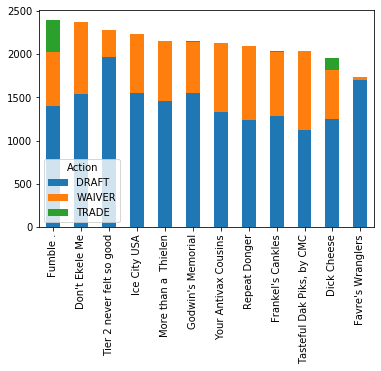

In [103]:
df_scoring_by_acq.plot(kind='bar',stacked=True)

In [104]:
s

Fumble .                     2397.9
Don't Ekele Me               2368.9
Tier 2 never felt so good    2282.1
Ice City USA                 2234.7
More than a  Thielen         2150.5
Godwin's Memorial            2147.6
Your Antivax Cousins         2128.0
Repeat Donger                2097.8
Frankel's Cankles            2039.2
Tasteful Dak Piks, by CMC    2033.9
Dick Cheese                  1958.9
Favre's Wranglers            1740.9
dtype: float64

In [106]:

df_stints_f


,Player,Position,Team,ProTeam,Action,Bid Amount ($),Stint (wks),Total points,Player-info
Stint,,,,,,,,,
0,Josh Allen,QB,Don't Ekele Me,BUF,DRAFT,13,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...",377.4,"Josh Allen, QB (BUF)"
1,Tom Brady,QB,Fumble .,TB,DRAFT,1,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...",354.5,"Tom Brady, QB (TB)"
2,Justin Herbert,QB,Frankel's Cankles,LAC,DRAFT,3,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...",352.3,"Justin Herbert, QB (LAC)"
3,Cooper Kupp,WR,Fumble .,LAR,DRAFT,29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15...",343.9,"Cooper Kupp, WR (LAR)"
4,Jonathan Taylor,RB,Godwin's Memorial,IND,DRAFT,58,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15...",342.1,"Jonathan Taylor, RB (IND)"
...,...,...,...,...,...,...,...,...,...
450,Ravens D/ST,D/ST,Tier 2 never felt so good,BAL,DRAFT,2,[1],-1.0,"Ravens D/ST, D/ST (BAL)"
451,Ravens D/ST,D/ST,Repeat Donger,BAL,WAIVER,1,[7],-6.0,"Ravens D/ST, D/ST (BAL)"
452,Jaguars D/ST,D/ST,Favre's Wranglers,JAX,WAIVER,1,"[16, 17]",-6.0,"Jaguars D/ST, D/ST (JAX)"


In [162]:
df_stints_f1 = df_stints_f[df_stints_f['Position'].isin(['WR'])]

In [163]:
df_stints_f1 = df_stints_f1.sort_values(by='Total points',ascending=False)

In [164]:
ls = df_stints_f1.iloc[0:11]['Player'].tolist()

In [165]:
df_player_box_scores

,Player,Position,Week,Team,Total points
1,Christian McCaffrey,RB,1,"Tasteful Dak Piks, by CMC",23.2
2,Davante Adams,WR,1,"Tasteful Dak Piks, by CMC",8.1
3,Justin Jefferson,WR,1,"Tasteful Dak Piks, by CMC",10.0
4,Steelers D/ST,D/ST,1,"Tasteful Dak Piks, by CMC",13.0
5,Dak Prescott,QB,1,"Tasteful Dak Piks, by CMC",29.3
...,...,...,...,...,...
2752,Devin Singletary,RB,17,Frankel's Cankles,23.0
2753,Daniel Carlson,K,17,Frankel's Cankles,13.0
2754,Courtland Sutton,WR,17,Frankel's Cankles,7.5
2755,Tyler Higbee,TE,17,Frankel's Cankles,9.9


In [145]:
df_temp = df_player_box_scores[['Player','Total points']].groupby('Player').agg(['count','mean','std'])

# df_temp = df_temp[df_temp['count'] >= 11]
# df_temp = df_temp.sort_values(by='mean',ascending=False)

In [146]:
df_temp = df_temp[df_temp['Total points']['count'] >= 11]
df_temp = df_temp.sort_values(by=['Total points','count'],ascending=False)

ValueError: The column label 'Total points' is not unique.
For a multi-index, the label must be a tuple with elements corresponding to each level.

In [147]:
df_player_box_scores['Player'].tolist()

['Christian McCaffrey',
 'Davante Adams',
 'Justin Jefferson',
 'Steelers D/ST',
 'Dak Prescott',
 'Jonnu Smith',
 'Henry Ruggs III',
 'James White',
 'J.D. McKissic',
 'Russell Gage',
 'Tyler Bass',
 'Jamison Crowder',
 'Chuba Hubbard',
 'Tony Pollard',
 'Joe Mixon',
 'Harrison Butker',
 'Najee Harris',
 'Chris Carson',
 'Julio Jones',
 'DeAndre Hopkins',
 'Kyler Murray',
 'Robert Tonyan',
 'Ravens D/ST',
 'Damien Harris',
 'AJ Dillon',
 'Matthew Stafford',
 'Marquez Callaway',
 'Nick Chubb',
 'Antonio Gibson',
 'Calvin Ridley',
 'Tyler Lockett',
 'Laviska Shenault Jr.',
 "Ja'Marr Chase",
 'Trey Sermon',
 'Ryan Tannehill',
 'Michael Carter',
 'Bills D/ST',
 'Mecole Hardman',
 'Tyler Higbee',
 'Graham Gano',
 'A.J. Brown',
 'Jonathan Taylor',
 'Buccaneers D/ST',
 'Chris Godwin',
 'Kyle Pitts',
 'Devin Singletary',
 'Logan Thomas',
 'Aaron Rodgers',
 'Sony Michel',
 'Darrell Henderson Jr.',
 'Raheem Mostert',
 'Michael Thomas',
 'Younghoe Koo',
 "Le'Veon Bell",
 'Alvin Kamara',
 'Patric

In [166]:
df = df_player_box_scores[df_player_box_scores['Player'].isin(ls)]

[Text(0, 0, 'Davante Adams'),
 Text(0, 0, 'Justin Jefferson'),
 Text(0, 0, "Ja'Marr Chase"),
 Text(0, 0, 'Tyreek Hill'),
 Text(0, 0, 'Cooper Kupp'),
 Text(0, 0, 'Keenan Allen'),
 Text(0, 0, 'Deebo Samuel'),
 Text(0, 0, 'Stefon Diggs'),
 Text(0, 0, 'Diontae Johnson'),
 Text(0, 0, 'Mike Evans'),
 Text(0, 0, 'DK Metcalf')]

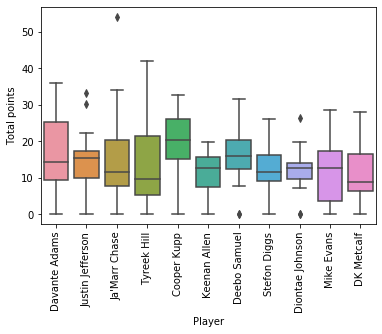

In [167]:
fig,ax=plt.subplots()
sns.boxplot(data=df,x='Player',y='Total points',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), Rotation= 90) 

In [119]:
df_player_box_scores.groupby('Player').agg('mean','std')['Total points']

KeyError: 'Total points'